In [71]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [72]:
data_train = pd.read_csv('ForecastWeather.csv')
data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [73]:
data_train.tail()

,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [74]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [75]:
#cek apakah ada nilai yang hilang dari dataset menggunakan fungsi isnull().
data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Text(0.5, 1.0, 'meantemp')

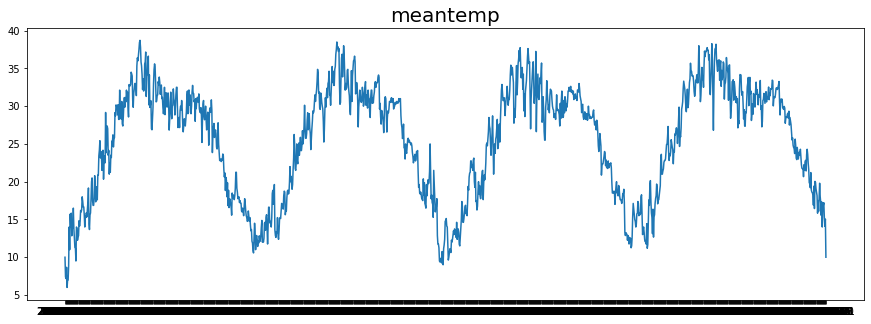

In [77]:
dates = data_train['date'].values
volume = data_train['meantemp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, volume)
plt.title('meantemp',
          fontsize=20)

In [78]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [79]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(volume, dates, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

1169 293


In [80]:
from keras.layers import Dense, LSTM

data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [81]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(data_x_train,epochs=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
12/12 [==============================] - 7s 280ms/step - loss: 19.4484 - mae: 19.9387
Epoch 2/100
12/12 [==============================] - 4s 280ms/step - loss: 18.5167 - mae: 19.0045
Epoch 3/100
12/12 [==============================] - 4s 278ms/step - loss: 17.5421 - mae: 18.0297
Epoch 4/100
12/12 [==============================] - 4s 280ms/step - loss: 16.8399 - mae: 17.3264
Epoch 5/100
12/12 [==============================] - 3s 277ms/step - loss: 16.3980 - mae: 16.8868
Epoch 6/100
12/12 [==============================] - 4s 280ms/step - loss: 16.1011 - mae: 16.5926
Epoch 7/100
12/12 [==============================] - 4s 279ms/step - loss: 15.8776 - mae: 16.3699
Epoch 8/100
12/12 [==============================] - 4s 277ms/step - loss: 15.7116 - mae: 16.2043
Epoch 9/100
12/12 [==============================] - 4s 280ms/step - loss: 15.5666 - mae: 16.0596
Epoch 10/100
12/12 [==============================] - 3s 277ms/step - loss: 15.4376 - mae: 15.9306
Epoch 11/100
12/12 

In [83]:
max = data_train['meantemp'].max()
print('Max value : ' )
print(max)

min = data_train['meantemp'].min()
print('Min Value : ')
print(min)

x = (90.0 - 1.0) * (10 / 100)
print(x)

Max value : 
38.714285714285715
Min Value : 
6.0
8.9


In [86]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nNilai MAE < 10% dari skala data ")
callbacks = myCallback()

tf.keras.backend.set_floatx('float64')
history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])


Epoch 1/500
12/12 [==============================] - 4s 337ms/step - loss: 6.8385 - mae: 7.3247 - val_loss: 5.7522 - val_mae: 6.2380

Nilai MAE < 10% dari skala data 
